<font size="-2">

### ***GROUP 10 - Lab Activity 5***
##### Baylon, Karyle Zhienelle V.
##### Francisco, Leann Joy Y.
##### Magtanong, Ralph Daven M.

</font>

[Bartlett] chi2=6791.66, dof=21.0, p=0
[KMO] overall=0.672
Q1 — Discriminant Analysis
Cross-validated accuracy (mean ± sd): 0.718 ± 0.018

Approx. Feature Importance (|LDA coefficients|):
gov_exp_pct_gdp_cap         0.654990
inflation_cpi_cap           0.499554
curr_acc_bal_pct_gdp_cap    0.431326
gdp_growth_cap              0.310509
unemployment_rate_cap       0.199185
gov_rev_pct_gdp_cap         0.153103
tax_rev_pct_gdp_cap         0.072655
dtype: float64


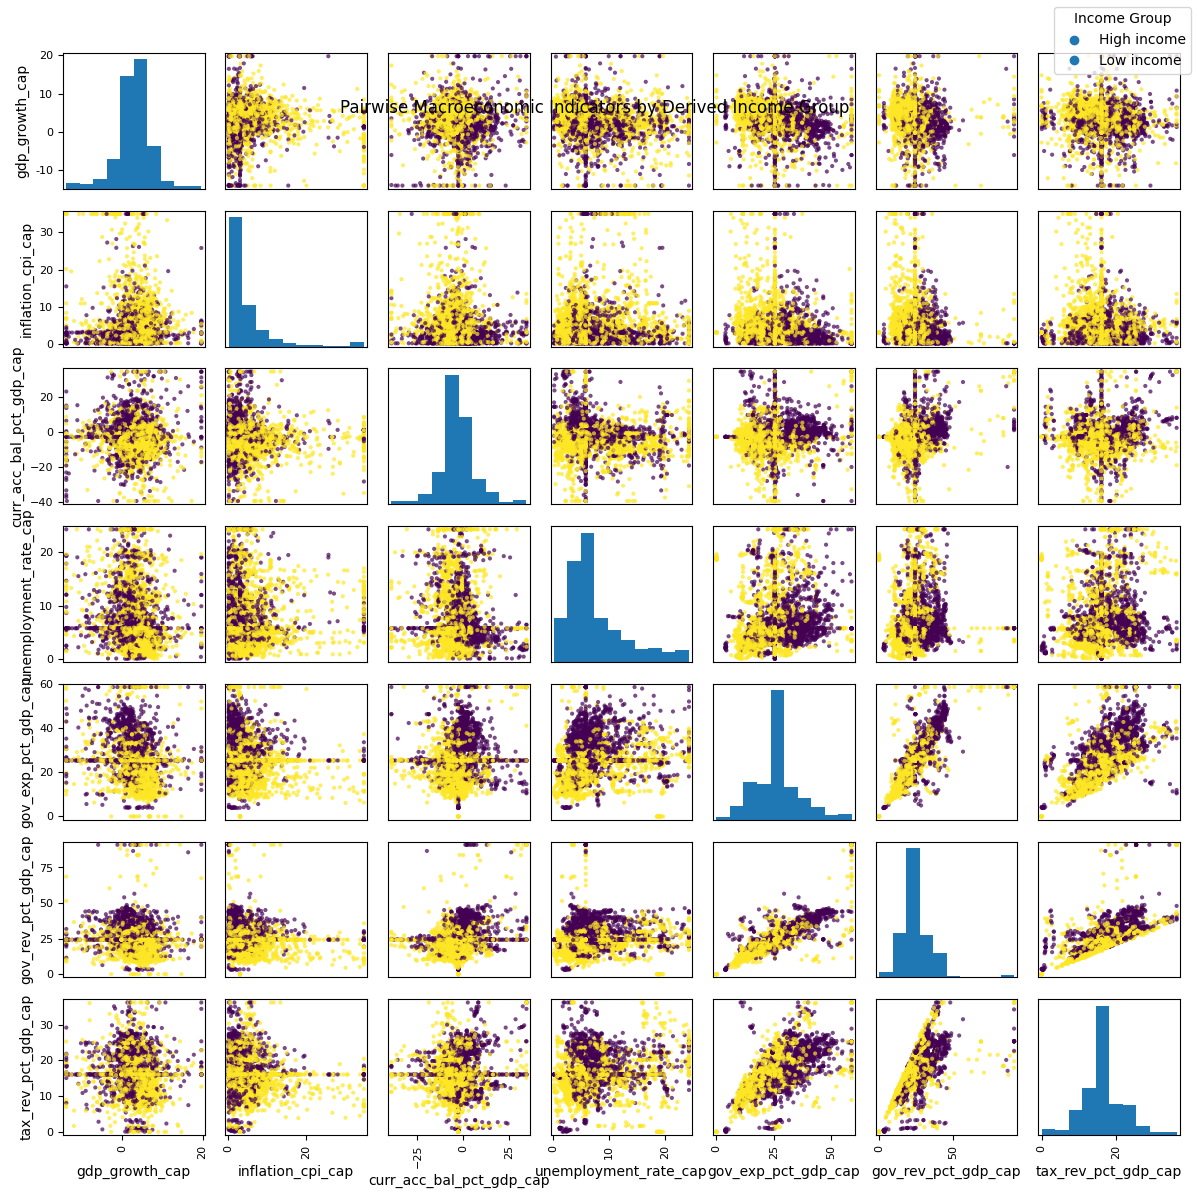

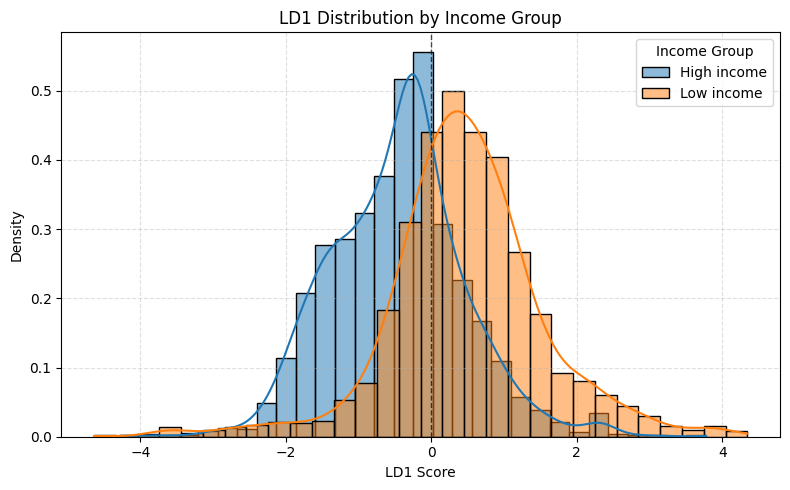

In [50]:
# Q1: Which combination of features best separates high-income vs. low-income countries?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from pandas.plotting import scatter_matrix
from scipy.stats import chi2

# 0) Config
CSV_PATH = "cleaned_world_bank_data_2025.csv"

FEATURE_COLS = [
    "gdp_growth_cap",             # GDP growth (%)
    "inflation_cpi_cap",          # Inflation (CPI, %)
    "curr_acc_bal_pct_gdp_cap",   # Current account balance (% of GDP)
    "unemployment_rate_cap",      # Unemployment rate (%)
    "gov_exp_pct_gdp_cap",        # Government expenditure (% of GDP)
    "gov_rev_pct_gdp_cap",        # Government revenue (% of GDP)
    "tax_rev_pct_gdp_cap",        # Tax revenue (% of GDP)
]

GDP_PC_COL = "gdp_pc_usd_cap"
GROUPING_MODE = "median"  # or "quantile"

# ---------- Preliminaries: Bartlett’s Test + KMO ----------
def bartlett_sphericity_test(Y_std):
    n, p = Y_std.shape
    R = np.corrcoef(Y_std, rowvar=False)
    detR = np.linalg.det(R); detR = max(detR, 1e-12)
    chi_square = -(n - 1 - (2*p + 5)/6) * np.log(detR)
    dof = p*(p-1)/2
    p_value = 1 - chi2.cdf(chi_square, dof)
    return chi_square, dof, p_value

def kmo_test(Y_std):
    R = np.corrcoef(Y_std, rowvar=False)
    invR = np.linalg.pinv(R)
    A = -invR / np.sqrt(np.outer(np.diag(invR), np.diag(invR)))
    np.fill_diagonal(A, 0.0)
    r2 = R**2; np.fill_diagonal(r2, 0.0)
    a2 = A**2; np.fill_diagonal(a2, 0.0)
    kmo_overall = r2.sum() / (r2.sum() + a2.sum())
    return kmo_overall

# Load & preprocess
df = pd.read_csv(CSV_PATH)
df_q1 = df.dropna(subset=FEATURE_COLS + [GDP_PC_COL]).copy()

# Create binary income group
if GROUPING_MODE == "median":
    thresh = df_q1[GDP_PC_COL].median()
    df_q1["IncomeGroup"] = np.where(df_q1[GDP_PC_COL] >= thresh, "High income", "Low income")
elif GROUPING_MODE == "quantile":
    q_low, q_high = df_q1[GDP_PC_COL].quantile([0.25, 0.75])
    df_q1 = df_q1[(df_q1[GDP_PC_COL] <= q_low) | (df_q1[GDP_PC_COL] >= q_high)].copy()
    df_q1["IncomeGroup"] = np.where(df_q1[GDP_PC_COL] >= q_high, "High income", "Low income")
else:
    raise ValueError("GROUPING_MODE must be 'median' or 'quantile'.")

# Keep only High vs Low income rows
df_q1 = df_q1[df_q1["IncomeGroup"].isin(["High income", "Low income"])]

X = df_q1[FEATURE_COLS].values
y = df_q1["IncomeGroup"].values

# Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Perform Bartlett’s Test and KMO Test
chi2_val, dof_val, p_bartlett = bartlett_sphericity_test(X_std)
kmo_overall = kmo_test(X_std)

print(f"[Bartlett] chi2={chi2_val:.2f}, dof={dof_val}, p={p_bartlett:.4g}")
print(f"[KMO] overall={kmo_overall:.3f}")

# 2) LDA fit, CV accuracy, feature importance
lda = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lda, X_std, y, cv=cv)
lda.fit(X_std, y)

print("Q1 — Discriminant Analysis")
print(f"Cross-validated accuracy (mean ± sd): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature importance proxy: abs standardized coefficients
coef = lda.coef_.ravel()
importance = pd.Series(np.abs(coef), index=FEATURE_COLS).sort_values(ascending=False)
print("\nApprox. Feature Importance (|LDA coefficients|):")
print(importance)

# 3) Visualization A: Scatter Plot Matrix
classes = np.unique(y)
class_to_num = {cls: i for i, cls in enumerate(classes)}
color_nums = df_q1["IncomeGroup"].map(class_to_num).values

axes = scatter_matrix(
    df_q1[FEATURE_COLS],
    figsize=(12, 12),
    diagonal='hist',
    c=color_nums,
    alpha=0.7
)

plt.suptitle("Pairwise Macroeconomic Indicators by Derived Income Group", y=0.92)

# Manual legend
handles = [plt.Line2D([0], [0], marker='o', linestyle='', label=cls) for cls in classes]
plt.figlegend(handles, classes, loc='upper right', title="Income Group")
plt.tight_layout()
plt.show()

# 4) Visualization B: LD1 Histogram / Density Overlay
X_ld = lda.transform(X_std)[:, 0]  # LD1 scores

plt.figure(figsize=(8, 5))
for cls in np.unique(y):
    mask = (y == cls)
    sns.histplot(
        X_ld[mask],
        kde=True, stat="density", bins=30,
        alpha=0.5, label=str(cls)
    )

plt.axvline(0, color="k", linestyle="--", lw=1, alpha=0.7)
plt.title("LD1 Distribution by Income Group")
plt.xlabel("LD1 Score")
plt.ylabel("Density")
plt.legend(title="Income Group")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

[Bartlett] chi2=11392.47, dof=45, p-value=0
[KMO] overall=0.624


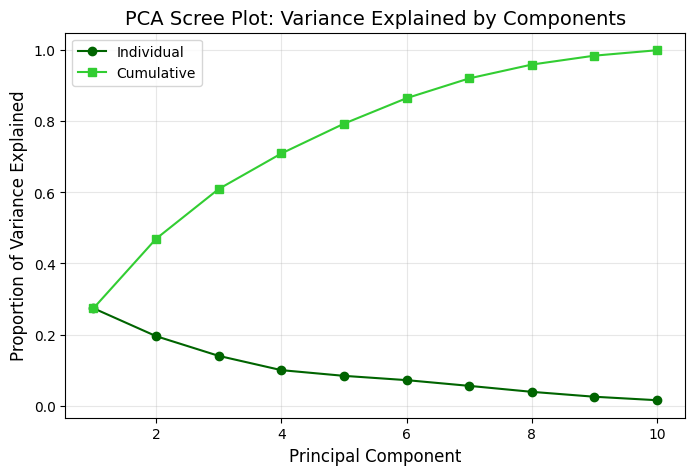

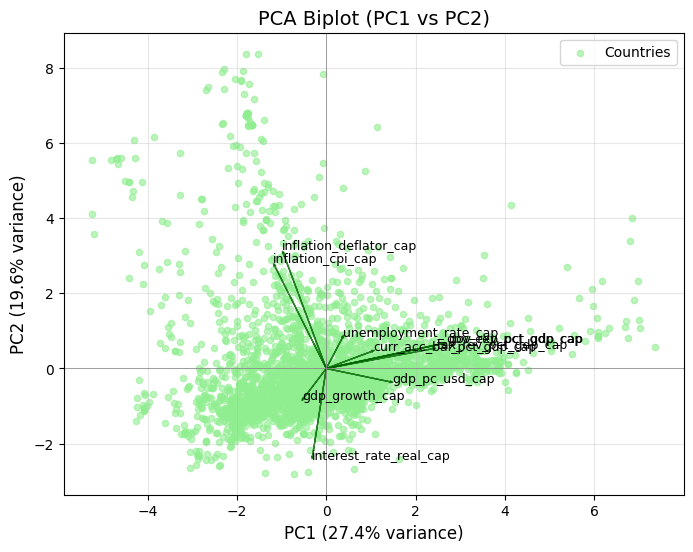

In [51]:
# Q2: Can we reduce macroeconomic indicators into a smaller set of key dimensions that explain most of the variance across countries?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from math import log
from scipy.stats import chi2

# ---------- Config ----------
CSV_PATH = "cleaned_world_bank_data_2025.csv"
ID_COLS = ["country_name","country_id","year"]
INDICATORS = [
    "gdp_pc_usd_cap", "inflation_cpi_cap", "unemployment_rate_cap",
    "interest_rate_real_cap", "inflation_deflator_cap", "gdp_growth_cap",
    "curr_acc_bal_pct_gdp_cap", "gov_exp_pct_gdp_cap",
    "gov_rev_pct_gdp_cap", "tax_rev_pct_gdp_cap"
]

# ---------- Load & prep ----------
df = pd.read_csv(CSV_PATH)
X = df[INDICATORS].dropna().copy()
X_std = StandardScaler().fit_transform(X.values)

# ---------- Preliminaries: Bartlett’s Test + KMO Test ----------
def bartlett_sphericity_test(X_std):
    n, p = X_std.shape
    R = np.corrcoef(X_std, rowvar=False)
    detR = np.linalg.det(R); detR = max(detR, 1e-12)
    chi_square = -(n - 1 - (2*p + 5)/6) * np.log(detR)
    dof = p*(p-1)/2
    p_value = 1 - chi2.cdf(chi_square, dof)
    return chi_square, dof, p_value

def kmo_test(X_std):
    R = np.corrcoef(X_std, rowvar=False)
    invR = np.linalg.pinv(R)
    A = -invR / np.sqrt(np.outer(np.diag(invR), np.diag(invR)))
    np.fill_diagonal(A, 0.0)
    r2 = R**2; np.fill_diagonal(r2, 0.0)
    a2 = A**2; np.fill_diagonal(a2, 0.0)
    kmo_j = r2.sum(axis=0) / (r2.sum(axis=0) + a2.sum(axis=0))
    kmo_overall = r2.sum() / (r2.sum() + a2.sum())
    return kmo_overall, kmo_j

chi2_val, dof_val, p_bartlett = bartlett_sphericity_test(X_std)
kmo_overall, kmo_each = kmo_test(X_std)

print(f"[Bartlett] chi2={chi2_val:.2f}, dof={dof_val:.0f}, p-value={p_bartlett:.4g}")
print(f"[KMO] overall={kmo_overall:.3f}")

# ---------- PCA ----------
pca = PCA()
pcs = pca.fit_transform(X_std)

explained = pca.explained_variance_ratio_
cumexp = np.cumsum(explained)

# ---------- Visualization 1: Scree Plot ----------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), explained, marker='o', color="darkgreen", label="Individual")
plt.plot(range(1, len(cumexp)+1), cumexp, marker='s', color="limegreen", label="Cumulative")
plt.title("PCA Scree Plot: Variance Explained by Components", fontsize=14)
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Proportion of Variance Explained", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------- Visualization 2: PCA Biplot ----------
pc1, pc2 = pcs[:,0], pcs[:,1]
loadings = pca.components_.T[:,0:2]  # PC1 & PC2 loadings

plt.figure(figsize=(8,6))
plt.scatter(pc1, pc2, alpha=0.6, color="lightgreen", s=20, label="Countries")

# Draw variable loadings (arrows)
for i, var in enumerate(INDICATORS):
    plt.arrow(0, 0, loadings[i,0]*5, loadings[i,1]*5,
              color="darkgreen", alpha=0.8, head_width=0.05)
    plt.text(loadings[i,0]*5.2, loadings[i,1]*5.2, var, color="black", fontsize=9)

plt.title("PCA Biplot (PC1 vs PC2)", fontsize=14)
plt.xlabel(f"PC1 ({explained[0]*100:.1f}% variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% variance)", fontsize=12)
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


[Bartlett] chi2=394.31, dof=3.0, p=0
[KMO] overall=0.691

Correlations with GDP growth:
                     gdp_growth_cap
gov_exp_pct_gdp_cap       -0.336487
gov_rev_pct_gdp_cap       -0.259699
tax_rev_pct_gdp_cap       -0.203620
fiscal_factor1            -0.314989


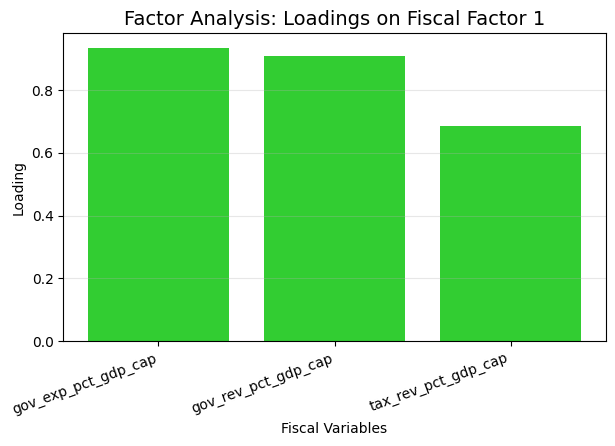

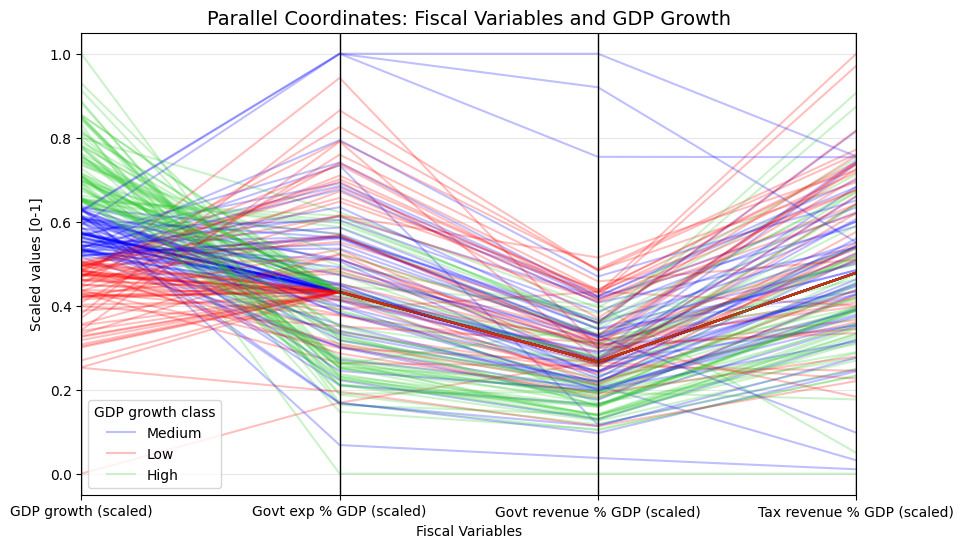

In [52]:
# Q3: How strongly are fiscal variables (government expenditure, revenue, and tax revenue as % of GDP) correlated with GDP growth across countries?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from pandas.plotting import parallel_coordinates
from scipy.stats import chi2

# ---------- Config ----------
CSV_PATH = "cleaned_world_bank_data_2025.csv"
ID_COLS = ["country_name", "country_id", "year"]
INDICATORS = [
    "gdp_growth_cap",       # GDP growth (annual %)
    "gov_exp_pct_gdp_cap",  # Government expenditure (% GDP)
    "gov_rev_pct_gdp_cap",  # Government revenue (% GDP)
    "tax_rev_pct_gdp_cap"   # Tax revenue (% GDP)
]

# ---------- Load & prep ----------
df = pd.read_csv(CSV_PATH)
X = df[INDICATORS + ID_COLS].dropna().copy()

# Keep latest year per country
X = X.sort_values(["country_name","year"])
X_latest = X.groupby("country_name").tail(1).reset_index(drop=True)

# Fiscal variables only
fiscal_vars = ["gov_exp_pct_gdp_cap","gov_rev_pct_gdp_cap","tax_rev_pct_gdp_cap"]
Y = X_latest[fiscal_vars].values
Y_std = StandardScaler().fit_transform(Y)

# ---------- Preliminaries: Bartlett’s Test + KMO ----------
def bartlett_sphericity_test(Y_std):
    n, p = Y_std.shape
    R = np.corrcoef(Y_std, rowvar=False)
    detR = np.linalg.det(R); detR = max(detR, 1e-12)
    chi_square = -(n - 1 - (2*p + 5)/6) * np.log(detR)
    dof = p*(p-1)/2
    p_value = 1 - chi2.cdf(chi_square, dof)
    return chi_square, dof, p_value

def kmo_test(Y_std):
    R = np.corrcoef(Y_std, rowvar=False)
    invR = np.linalg.pinv(R)
    A = -invR / np.sqrt(np.outer(np.diag(invR), np.diag(invR)))
    np.fill_diagonal(A, 0.0)
    r2 = R**2; np.fill_diagonal(r2, 0.0)
    a2 = A**2; np.fill_diagonal(a2, 0.0)
    kmo_overall = r2.sum() / (r2.sum() + a2.sum())
    return kmo_overall

chi2_val, dof_val, p_bartlett = bartlett_sphericity_test(Y_std)
kmo_overall = kmo_test(Y_std)

print(f"[Bartlett] chi2={chi2_val:.2f}, dof={dof_val}, p={p_bartlett:.4g}")
print(f"[KMO] overall={kmo_overall:.3f}")

# ---------- Factor Analysis ----------
fa = FactorAnalysis(n_components=1, random_state=42)
factor_scores = fa.fit_transform(Y_std)
loadings = fa.components_.T[:,0]

X_latest["fiscal_factor1"] = factor_scores[:,0]

# Correlations with GDP growth
corr = X_latest[["gdp_growth_cap"] + fiscal_vars + ["fiscal_factor1"]].corr()
print("\nCorrelations with GDP growth:")
print(corr.loc[["gdp_growth_cap"], fiscal_vars + ["fiscal_factor1"]].T)

# ---------- Visualization 1: Factor Loadings ----------
plt.figure(figsize=(7,4))
plt.bar(fiscal_vars, loadings, color="limegreen")
plt.title("Factor Analysis: Loadings on Fiscal Factor 1", fontsize=14)
plt.xlabel("Fiscal Variables")
plt.ylabel("Loading")
plt.xticks(rotation=20, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.show()

# ---------- Visualization 2: Parallel Coordinates ----------
# Create terciles of GDP growth for color-coding
X_latest["growth_class"] = pd.qcut(X_latest["gdp_growth_cap"], 3, labels=["Low","Medium","High"])

# Scale variables for plotting
to_scale = ["gdp_growth_cap"] + fiscal_vars
scaled = (X_latest[to_scale] - X_latest[to_scale].min()) / (X_latest[to_scale].max() - X_latest[to_scale].min())
plot_df = pd.concat([X_latest[["growth_class"]], scaled], axis=1)

plt.figure(figsize=(10,6))
parallel_coordinates(
    plot_df.rename(columns={
        "gdp_growth_cap": "GDP growth (scaled)",
        "gov_exp_pct_gdp_cap": "Govt exp % GDP (scaled)",
        "gov_rev_pct_gdp_cap": "Govt revenue % GDP (scaled)",
        "tax_rev_pct_gdp_cap": "Tax revenue % GDP (scaled)"
    }),
    "growth_class",
    alpha=0.25,
    color=["blue", "red", "limegreen"]
)
plt.title("Parallel Coordinates: Fiscal Variables and GDP Growth", fontsize=14)
plt.xlabel("Fiscal Variables")
plt.ylabel("Scaled values [0-1]")
plt.legend(title="GDP growth class")
plt.grid(alpha=0.3)
plt.show()